In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg
#%matplotlib inline
import pandas as pd
import os

C:\Users\cihsato\Anaconda3\envs\tensorflow16\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\cihsato\Anaconda3\envs\tensorflow16\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\cihsato\Anaconda3\envs\tensorflow16\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


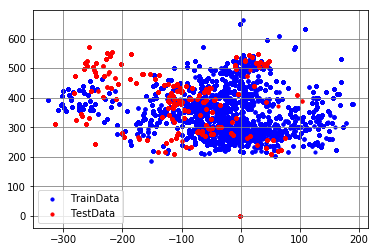

In [2]:
#----------TRAIN-------------#
target_path = '../data/chisato/goal/'
contents = os.listdir(target_path)
data = pd.DataFrame()
num = 0
for c in range(len(contents)):
    #print(target_path+contents[c])
    n_data = pd.read_csv(target_path+contents[c],header=None)
    data = pd.concat([data,n_data])
plt.hold(True)
plt.grid(color='gray')
plt.scatter(data[1],data[0], s=10, c='blue',label='TrainData')
    
#----------TEST-------------#
test_path = '../data/test/log201806251817.csv'
contents = os.listdir(target_path)
test_data = pd.read_csv(test_path,header=None)
plt.grid(color='gray')
plt.scatter(test_data[1],test_data[0], s=10, c='red',label='TestData')
plt.legend()

In [3]:
IN_size = 2
TAR_size = 2
INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

hidden_size = [25]
batch_size = 100
iter_size = 50000

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]

loss = tf.losses.mean_squared_error(TARGET,final_output)

Tensor("Relu:0", shape=(?, 25), dtype=float32)


In [4]:
# 重みのrestore
saver = tf.train.Saver()
predicts_sess = tf.Session()
ckpt = tf.train.get_checkpoint_state('./')
if ckpt == None:
    print('!!!!!!!WEIGHTS NOT FOUND!!!!!!')

saver.restore(predicts_sess, './model.ckpt')

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [5]:
test_data.columns = ['bx','by','jx','jy']
test_data = test_data[test_data.bx!=-1]
s_INPUT = np.array(test_data.iloc[:,0:2])
print(s_INPUT.shape)
s_ANS = np.array(test_data.iloc[:,2:4])
print(s_ANS.shape)
pred = np.empty((0,3),np.float32)
for i in range(len(s_INPUT)):
    s_input = np.array([s_INPUT[i]])/100
    s_ans = np.array([s_ANS[i]])
    #s_ans = np.array([s_ANS[i]])/100
    res = predicts_sess.run(final_output, feed_dict={INPUT: s_input})
    test_loss = predicts_sess.run(loss, feed_dict={INPUT: s_input,TARGET:s_ans})
    #print(np.c_[test_loss, s_input])
    col = np.c_[test_loss, s_input]
    pred = np.append(pred, col, axis=0)
    
p_pred = pd.DataFrame(pred,columns=list('pxy'))
sorted_data = p_pred.sort_values(by='p',ascending=False) #p列において値の大きい順にソート
print(len(pred))

(2014, 2)
(2014, 2)
2014


C:\Users\cihsato\Anaconda3\envs\tensorflow16\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
C:\Users\cihsato\Anaconda3\envs\tensorflow16\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\cihsato\Anaconda3\envs\tensorflow16\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


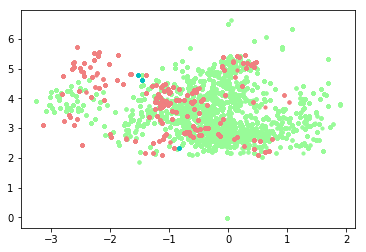

In [6]:
plt.hold(True)
plt.scatter(data[1]/100,data[0]/100, s=10, c='palegreen',label='TrainData')

thresh = 1

#----------TEST-------------#
for t in range(len(pred)):
    if pred[t][0] < thresh: #まあほぼ正解
        plt.scatter(pred[t][2],pred[t][1], s=10, c='lightcoral')
    else: #失敗
        plt.scatter(pred[t][2],pred[t][1], s=10, c='c')
        
        


In [44]:

def _update_plot(i,ball,Q):
    if i != 0:
        plt.cla()
        
    plt.xlim([-10, 10])
    plt.ylim([0, 10])

    bx = s_INPUT[i][0]/100.0
    by = s_INPUT[i][1]/100.0
    
    U = s_ANS[i][0] * 100
    V = s_ANS[i][1] * 100
    ball.set_data = (bx, by)
    Q.set_UVC(U,-V)

    #joy = plt.quiver(0,0,U,V,angles="xy",scale_units="xy",scale=1)

<IPython.core.display.Javascript object>


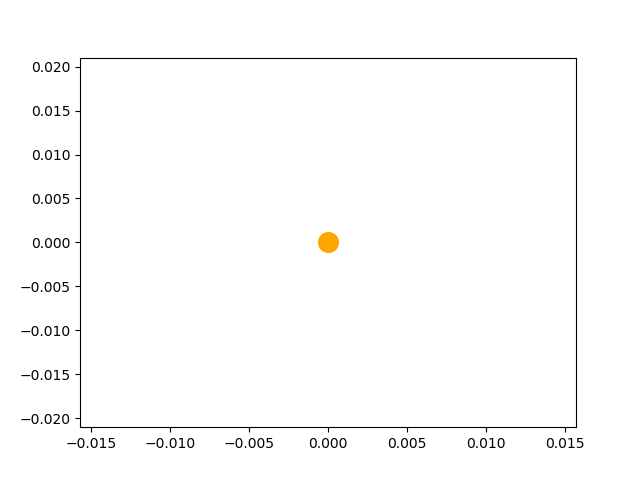

TypeError: 'PathCollection' object is not iterable

In [45]:
#  アニメーション(黒：私の入力, 青：予測)
fig = plt.figure()
ball, = plt.scatter(0,0, s=200, c='orange')
Q, = plt.quiver(0,0,0,0,angles="xy",scale_units="xy",scale=1)
#プロットするもの　ボールの位置，s_INPUTのj_x j_y，pred[1] pred[2]
print(s_INPUT.shape)
print(s_ANS.shape)
anim = animation.FuncAnimation(fig, _update_plot,fargs=(ball,Q), frames=len(s_INPUT), blit=False, interval=100)
plt.show()
